In [1]:
import os
import random
import torch
import pandas as pd

import utils
import similarity

import matplotlib
from matplotlib import pyplot as plt

In [2]:
#Arguments

clip_name = 'ViT-B/16'#"ViT-B/32"#"ViT-B/16"#"ViT-L/14"
target_name = 'resnet50' #'resnet50' 'resnet18_places'
target_layer = 'fc' #'layer4' 'layer1'
d_probe = 'cifar100_train'#"cifar100_train"#"cifar100_val",#"imagenet_train"#"imagenet_val"#"broden"#"imagenet_broden"
concept_set = 'data/imagenet_labels.txt'#'data/20k.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
target_preprocess = utils.get_resnet_imagenet_preprocess()
similarity_fn = similarity.soft_wpmi #wpmi, rank_reorder

In [3]:
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer], 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, target_preprocess = target_preprocess,
                      save_dir = save_dir)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names

similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                             text_save_name, similarity_fn)

with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

pil_data = utils.get_pil_data(d_probe)

100%|██████████| 1000/1000 [00:00<00:00, 3406.69it/s]


Files already downloaded and verified


torch.Size([1000, 1000])
torch.Size([50000, 1000])

 Layer:fc Neuron:131
3.6215 little blue heron, Egretta caerulea
2.6996 European gallinule, Porphyrio porphyrio
2.4779 African grey, African gray, Psittacus erithacus
2.1943 limpkin, Aramus pictus
2.1654 water ouzel, dipper


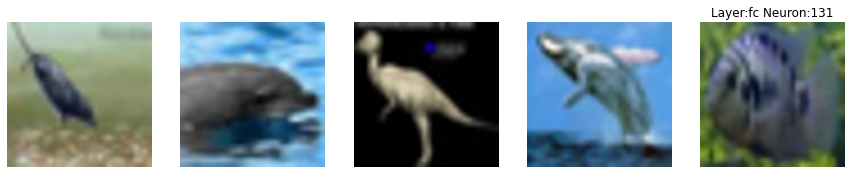


 Layer:fc Neuron:132
3.2277 American egret, great white heron, Egretta albus
2.5107 little blue heron, Egretta caerulea
2.4434 spoonbill
2.1967 sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita
1.9839 bald eagle, American eagle, Haliaeetus leucocephalus


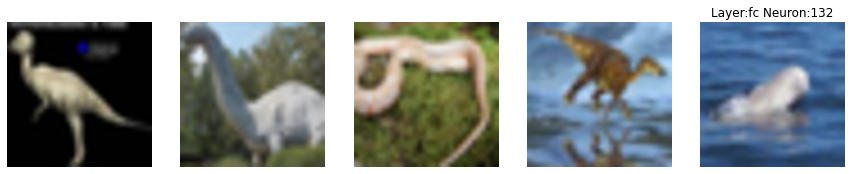

In [5]:
print(similarities.shape)
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)

print(target_feats.shape)
#ids_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
ids_to_check = [131, 132]

for orig_id in ids_to_check:

    print('\n Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
    for i in range(len(vals)):
        print("{:.4f}".format(vals[i]), words[int(ids[i])])
    
    fig = plt.figure(figsize=(15, 7))
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        fig.add_subplot(1, 5, i+1)
        plt.imshow(im)
        plt.axis('off')
        
    plt.title('Layer:{} Neuron:{}'.format(target_layer, (int(orig_id))))
    plt.show()

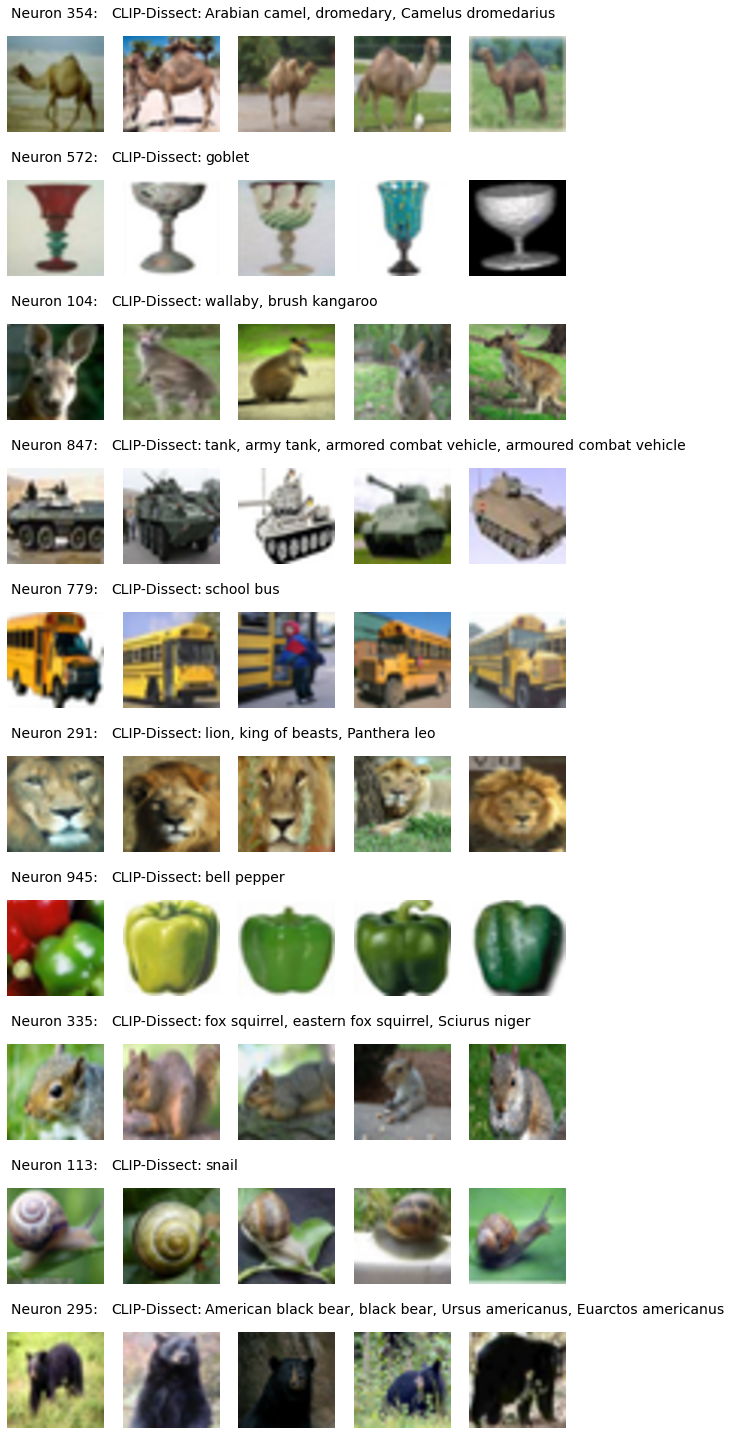

In [6]:
ids_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:10]
font_size=14
font = {'size'   : font_size}#'family' : 'normal',
        #'weight' : 'bold',

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(ids_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(ids_to_check), ncols=1)
for j, orig_id in enumerate(ids_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
        
    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')
    #fig.tight_layout()
plt.show()